# Tenencia del producto préstamo en el DataSet de Banco Checo  

Vamos a intentar extraer del datset generado que variables son las más relevantes para que una cuenta (account) tenga un péstamo (loan) y ver si de esta forma podemos generar un customer journey para conseguir que un cliente contrate un préstamo

In [1]:
import pandas as pd
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Cargamos los datos que hemos procesado en R
df_original= pd.read_csv("C://Master Data Science/Master en Data Science/TFM/Transacciones de Banco Checo/DFTenenciaProductos2.csv")

In [3]:
#Comenzamos a revisar que el DF se haya importado correctamente
df_original.shape

(4500, 70)

In [4]:
df_original.head()

,Unnamed: 0,district_id,account_id,frequency,Date_Account,client_id_owner,client_id_disponent,sex_owner,birth_owner,sex_disponent,...,Num_Sym_Pension,Num_Sym_Insurance,Num_Sym_NegBal,Num_Sym_Household,Num_Sym_Statement,Num_Sym_IntDep,Num_Sym_LoanPayment,Balance_in_negative,account_disponent_bin,account_loan_bin
0,1,1,1938,Monthly,1994-06-25,2354,NaN,M,1967-12-21,NaN,...,0,0,0,50,49,54,0,0,0,0
1,2,1,1562,Monthly,1995-08-30,1894,NaN,F,1947-11-05,NaN,...,0,0,0,36,35,36,0,0,0,0
2,3,1,7099,Monthly,1996-08-20,8568,NaN,F,1971-12-03,NaN,...,0,24,0,24,23,28,7,0,0,1
3,4,1,2316,Monthly,1997-07-21,2802,NaN,F,1966-11-29,NaN,...,0,0,0,13,12,17,0,0,0,0
4,5,1,1570,Monthly,1994-03-12,1903,NaN,F,1939-08-30,NaN,...,57,0,0,53,52,53,0,0,0,0


In [5]:
# Vamos a analizar si hay missings al cargar los datos a Python
df_original.columns[df_original.isnull().sum()!=0]
#Vemos que las variables con missings provienen de variables que ya tenían esos missings en el DataFrame generado con R,
#ya que el disponent (autorizado), los préstamos y las tarjetas no son productos que tengan asociados todas las cuentas  

Index(['client_id_disponent', 'sex_disponent', 'birth_disponent', 'loan_id',
       'Date_Loan', 'Amount_Loan', 'Duration_Loan', 'Payments_Loan', 'status',
       'Status_Loan', 'owner_card_date'],
      dtype='object')

In [6]:
#Vemos como se han importado las variables del DataFrame de R al DataFrame que vamos a utilizar en Python 
print(df_original.iloc[:,0:32].dtypes)
print(df_original.iloc[:,31:61].dtypes)
print(df_original.iloc[:,60:70].dtypes)
#Observamos que las variables de factor y de fecha han modificado su tipo de variable, 
#por lo que tendremos que trabajar con ellas

Unnamed: 0                        int64
district_id                       int64
account_id                        int64
frequency                        object
Date_Account                     object
client_id_owner                   int64
client_id_disponent             float64
sex_owner                        object
birth_owner                      object
sex_disponent                    object
birth_disponent                  object
loan_id                         float64
Date_Loan                        object
Amount_Loan                     float64
Duration_Loan                   float64
Payments_Loan                   float64
status                           object
Status_Loan                      object
Ord_Insurance                     int64
Ord_Insurance_amount              int64
Ord_Household_Payment             int64
Ord_Household_Payment_amount      int64
Ord_Loan_Payment                  int64
Ord_Loan_Payment_amount         float64
Ord_Leasing                       int64


In [7]:
#Transformamos a formato fecha las variables que originalmente eran fecha en R
df_original[["Date_Account","birth_owner", "birth_disponent", "Date_Loan", "owner_card_date"]]=df_original[["Date_Account","birth_owner", "birth_disponent", "Date_Loan", "owner_card_date"]].apply(pd.to_datetime)
from datetime import datetime
df_original['Date_Account']=df_original['Date_Account'].apply(datetime.toordinal)
df_original['birth_owner']=df_original['birth_owner'].apply(datetime.toordinal)
df_original['birth_disponent']=df_original['birth_disponent'].apply(datetime.toordinal)
df_original['Date_Loan']=df_original['Date_Loan'].apply(datetime.toordinal)
df_original['owner_card_date']=df_original['owner_card_date'].apply(datetime.toordinal)

In [8]:
#De todas las variables de las que disponemos, vamos a seleccionar las que vamos a utilizar en este ejercicio:

#La  variable que vamos a predecir va a ser "account_loan_bin" y por tanto la denominaremos "y"

#Para este ejercicio no consideramos las variables que hemos obtenido en el mismo fichero que la variable a predecir (loan.csv):
#loan_id, Date_Loan, Amount_Loan, Duration_Loan, Payments_Loan, status, Status_Loan.

#Otras variables que no consideramos: account_id, client_id_owner, client_id_disponent, district ID y unnamed:0 porque 
#son ID's descriptivas sin información para utilizar

#La variable disponent_card_type no aporta información

#Otras variables que no consideramos:district_name, region (nombre). Utilizamos el resto de la información de variables 
#del fichero district.csv

#Haciendo referencia a district.csv , la información de crimes_95, crimes_96 y entrepreneurs la vamos a utilizar como ratio,
#ya que como veremos a continuación, de esta forma obtendremos menos impacto por un distrito con mucha población (Praga) 



In [9]:
#Las variables crimes_95, crimes_96 y entrepreneurs vamos a utilizarlas en formato ratio, tal y como calculamos en R

(array([3443.,  240.,  263.,    0.,    0.,    0.,    0.,    0.,    0.,
         554.]),
 array([  818. ,  9303.9, 17789.8, 26275.7, 34761.6, 43247.5, 51733.4,
        60219.3, 68705.2, 77191.1, 85677. ]),
 <a list of 10 Patch objects>)

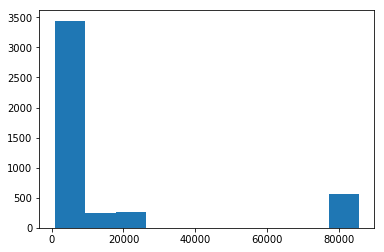

In [10]:
plt.hist(df_original['crimes_95'])

(array([ 596., 1052.,  499.,  760.,  370.,  317.,  128.,  224.,    0.,
         554.]),
 array([0.01354271, 0.01929884, 0.02505497, 0.0308111 , 0.03656723,
        0.04232336, 0.04807949, 0.05383562, 0.05959176, 0.06534789,
        0.07110402]),
 <a list of 10 Patch objects>)

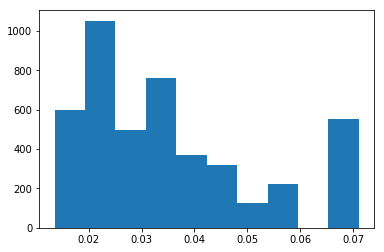

In [11]:
plt.hist(df_original['crimes_95_ratio'])

(array([3683.,  263.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         554.]),
 array([  888. , 10709.9, 20531.8, 30353.7, 40175.6, 49997.5, 59819.4,
        69641.3, 79463.2, 89285.1, 99107. ]),
 <a list of 10 Patch objects>)

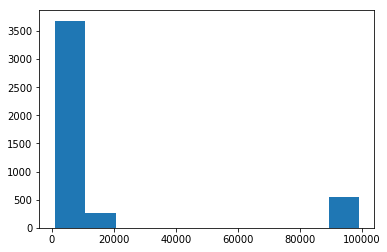

In [12]:
plt.hist(df_original['crimes_96'])

(array([1141.,  804.,  726.,  637.,  415.,   88.,  135.,    0.,    0.,
         554.]),
 array([0.0159461 , 0.02257646, 0.02920682, 0.03583717, 0.04246753,
        0.04909789, 0.05572825, 0.06235861, 0.06898896, 0.07561932,
        0.08224968]),
 <a list of 10 Patch objects>)

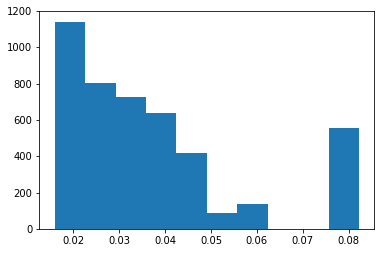

In [13]:
plt.hist(df_original['crimes_96_ratio'])

(array([200., 354., 644., 992., 517., 757., 259., 138.,  85., 554.]),
 array([ 81. ,  89.6,  98.2, 106.8, 115.4, 124. , 132.6, 141.2, 149.8,
        158.4, 167. ]),
 <a list of 10 Patch objects>)

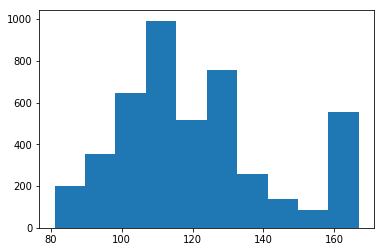

In [14]:
plt.hist(df_original['entrepreneurs'])

(array([ 969.,  322., 1256.,  793.,  312.,  388.,  177.,  192.,   43.,
          48.]),
 array([0.00013859, 0.00041431, 0.00069003, 0.00096575, 0.00124147,
        0.00151719, 0.0017929 , 0.00206862, 0.00234434, 0.00262006,
        0.00289578]),
 <a list of 10 Patch objects>)

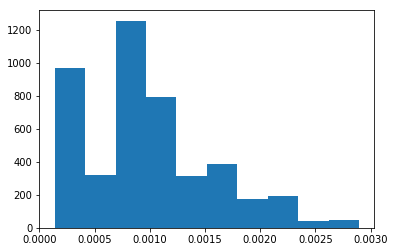

In [15]:
plt.hist(df_original['entrepreneurs_ratio'])

In [16]:
#Creamos un DataFrame con las variables que vamos a considerar numéricas
df_num=df_original[['Date_Account','birth_owner', 'birth_disponent','owner_card_date','Ord_Insurance', 'Ord_Insurance_amount',
                    'Ord_Household_Payment','Ord_Household_Payment_amount', 'Ord_Loan_Payment', 'Ord_Leasing',
                    'Ord_Empty', 'Ord_Empty_amount', 'num_inhabitants', 'municip < 499', 'municip 500-1999',
                    'municip 2000-9999', 'municip > 10000', 'num_cities', 'avg_salary',  
                    'Num_Type_Credit', 'Num_Type_VYBER', 'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
                    'Num_Op_Collection','Num_Op_CashCredit', 'Num_Op_WithdrawalCash','Num_Op_WithdrawalCreditCard',
                    'Num_Sym_Null', 'Num_Sym_Null2','Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
                    'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep', 'Num_Sym_LoanPayment', 
                    'Balance_in_negative','Ord_Loan_Payment_amount', 'Ord_Leasing_amount','ratio_urban_inhabitants',
                    'unemployment_rate_95','unemployment_rate_96', 'crimes_95_ratio', 'crimes_96_ratio', 'entrepreneurs_ratio' ]] 

In [17]:
#Creamos un DataFrame con las variables que vamos a considerar categóricas
df_cat=df_original[['account_disponent_bin','frequency', 'sex_owner', 'owner_card_type',
       'sex_disponent']]
#Vemos que tipos tienen las variables que queremos que sean categóricas
df_cat.dtypes

account_disponent_bin     int64
frequency                object
sex_owner                object
owner_card_type           int64
sex_disponent            object
dtype: object

In [18]:
#Ponemos las variables "owner_card_type" y "account_disponent_bin" como string para poder obtener dummies
df_cat["owner_card_type"]=df_cat["owner_card_type"].astype(str)
df_cat["account_disponent_bin"]=df_cat["account_disponent_bin"].astype(str)

C:\Users\osmaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\osmaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
df_cat_dumm=pd.get_dummies(df_cat)

In [20]:
df_cat_dumm.dtypes
#Al pasar a dummies las variables, hemos incrementado en 8 el número total de variables

account_disponent_bin_0    uint8
account_disponent_bin_1    uint8
frequency_After_trans      uint8
frequency_Monthly          uint8
frequency_Weekly           uint8
sex_owner_F                uint8
sex_owner_M                uint8
owner_card_type_0          uint8
owner_card_type_1          uint8
owner_card_type_2          uint8
owner_card_type_3          uint8
sex_disponent_F            uint8
sex_disponent_M            uint8
dtype: object

In [21]:
df = pd.concat([df_num, df_cat_dumm], axis = 1)
df.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Loan_Payment,Ord_Leasing,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,728104,718421,1,1,0,0,1,6646,0,1,...,1,0,0,1,1,0,0,0,0,0
1,728535,711070,1,1,0,0,1,1933,0,0,...,1,0,1,0,1,0,0,0,0,0
2,728891,719864,1,1,1,528,1,236,1,0,...,1,0,1,0,1,0,0,0,0,0
3,729226,718034,1,1,0,0,1,2111,0,0,...,1,0,1,0,1,0,0,0,0,0
4,727999,708081,1,1,0,0,1,2865,0,0,...,1,0,1,0,1,0,0,0,0,0


# Vamos a generar un primer modelo benchmark

In [22]:
#Antes de probar con modelos vamos a ver si reduciendo dimensionalidad conseguimos una primera intuición

In [23]:
X = df
y = df_original["account_loan_bin"] 

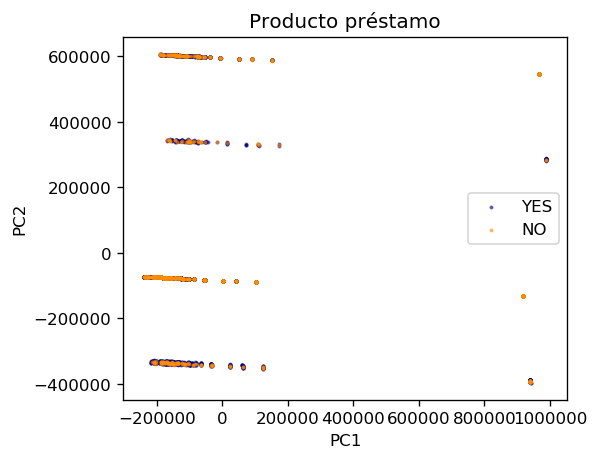

In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(X)
plt.figure(dpi=120)
plt.scatter(pca[y.values==0,0], pca[y.values==0,1], alpha=0.5, label='YES', s=2, color='navy')
plt.scatter(pca[y.values==1,0], pca[y.values==1,1], alpha=0.5, label='NO', s=2, color='darkorange')
plt.legend()
plt.title('Producto préstamo')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.gca().set_aspect('equal')
plt.show()

In [25]:
#Del gráfico anterior no consigo sacar nada en claro
pca2 = PCA(n_components=2)
pca2.fit(X)
print(pca2.components_)
print(pca2.explained_variance_ratio_)
#De los componentes una intuición de que quizás las variables 3 ('birth_disponent'),4 ('owner_card_date') y 
#13 'num_inhabitants' podrían ser importantes

[[-1.41899145e-05  3.76112969e-04  2.97418890e-02  6.65291847e-02
   1.10456611e-08  6.97541426e-05 -8.13236480e-09  4.49340526e-05
   1.92086580e-09  1.51642509e-08  1.86478704e-08  1.40767450e-04
   9.97335487e-01 -4.90984072e-05 -2.32177716e-05 -5.72845134e-06
  -5.87189940e-07 -5.04538511e-06  3.32207470e-03  2.80449536e-06
   4.49809421e-07  3.59443953e-06  1.27687280e-06  5.86459693e-07
  -1.80003778e-06  3.32766034e-06  2.90427567e-06  5.53513591e-07
   3.95002345e-06  7.30692726e-07 -9.05250243e-07  3.92910956e-07
   9.53161761e-08  5.39244984e-07  4.59238406e-07  1.27687280e-06
   3.09695048e-07  3.58832264e-07  4.66633456e-05  4.45604444e-05
   3.74408574e-05 -2.48007137e-06 -2.94393181e-06  3.92241114e-08
   4.83722236e-08 -1.07124667e-09 -4.19281050e-08  4.19281050e-08
  -4.73145522e-09 -5.56504707e-09  1.02965023e-08  3.63305616e-09
  -3.63305616e-09 -9.12049432e-08  6.41757903e-08  4.74961153e-09
   2.22795413e-08  2.15292322e-08  2.03988728e-08]
 [ 3.04437369e-06  3.7370

In [26]:
#Pasamos a hacer modelos sencillos
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

In [27]:
#Generamos conjuntos de train y de test. Para el test usamos el 20% de las observaciones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
#Probamos una Regresión logística
clf_LR=LogisticRegression()
clf_LR.fit(X_train,y_train)

C:\Users\osmaa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
def eval_modelo (clf,X_train,y_train, X_test,y_test):
    print("Datos de train:")
    print("El accuracy es",accuracy_score(y_train,clf.predict(X_train))*100,"%")
    print("La precision es",precision_score(y_train,clf.predict(X_train))*100, "%")
    print("El recall es",recall_score(y_train,clf.predict(X_train))*100,"%")
    tn, fp, fn, tp=confusion_matrix(y_train,clf.predict(X_train)).ravel()
    print("tn:",tn," fp:",fp," fn:",fn," tp:",tp)
    print("Datos de test:")
    print("El accuracy es",accuracy_score(y_test,clf.predict(X_test))*100,"%")
    print("La precision es",precision_score(y_test,clf.predict(X_test))*100, "%")
    print("El recall es",recall_score(y_test,clf.predict(X_test))*100,"%")
    tn_t, fp_t, fn_t, tp_t=confusion_matrix(y_test,clf.predict(X_test)).ravel()
    print("tn:",tn_t," fp:",fp_t," fn:",fn_t," tp:",tp_t)      

In [30]:
eval_modelo(clf_LR,X_train,y_train, X_test,y_test)

Datos de train:
El accuracy es 97.25 %
La precision es 95.64315352697096 %
El recall es 85.52875695732838 %
tn: 3040  fp: 21  fn: 78  tp: 461
Datos de test:
El accuracy es 96.66666666666667 %
La precision es 94.48818897637796 %
El recall es 83.91608391608392 %
tn: 750  fp: 7  fn: 23  tp: 120


In [31]:
#Probamos con un árbol de decisión
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=5)
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [32]:
eval_modelo(clf_tree,X_train,y_train, X_test,y_test)

Datos de train:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 3061  fp: 0  fn: 0  tp: 539
Datos de test:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 757  fp: 0  fn: 0  tp: 143


In [33]:
#Los resultados de estos modelos tan sencillos están siendo extraordinarios. Vamos a investigar las razones.
#Además como las clases están desbalanceadas vamos a ir comparando el efecto de incluir oversampling o no. 
#Vamos a profundizar con Decission Trees en este primer modelo ya que tiene menores requerimientos teóricos para las features 

<function matplotlib.pyplot.show(*args, **kw)>

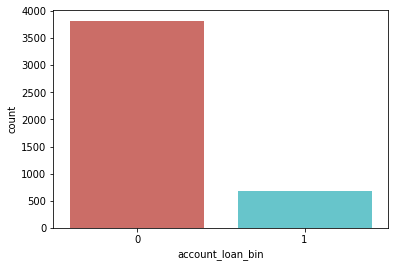

In [34]:
#Las clases a predecir de train (si la cuenta tiene prestamo=1 ó no tiene =0) están desbalanceadas
y2=pd.DataFrame(y)
sns.countplot(x="account_loan_bin",data=y2, palette='hls')
plt.show

In [35]:
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

In [36]:
#Función para dibujar un árbol
def dibu_arb(tree):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data,filled=True, rounded=True,
                special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return(Image(graph.create_png()))
    

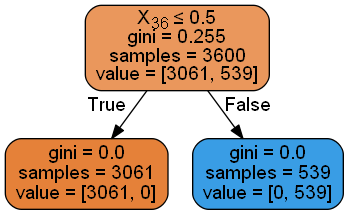

In [37]:
dibu_arb(clf_tree)

In [38]:
X_train.columns[36]
#Parece que la variable 'Num_Sym_LoanPayment' contiene toda la información "account_loan_bin", 
#aunque se han extraido de ficheros distintos

'Num_Sym_LoanPayment'

In [39]:
# conda install -c glemaitre imbalanced-learn

In [40]:
from imblearn.over_sampling import SMOTENC

In [41]:
#Para ver las columnas que vamos a denominar como categóricas  cuando apliquemos SMOTE
print(X_train.columns)

Index(['Date_Account', 'birth_owner', 'birth_disponent', 'owner_card_date',
       'Ord_Insurance', 'Ord_Insurance_amount', 'Ord_Household_Payment',
       'Ord_Household_Payment_amount', 'Ord_Loan_Payment', 'Ord_Leasing',
       'Ord_Empty', 'Ord_Empty_amount', 'num_inhabitants', 'municip < 499',
       'municip 500-1999', 'municip 2000-9999', 'municip > 10000',
       'num_cities', 'avg_salary', 'Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
       'Num_Op_Collection', 'Num_Op_CashCredit', 'Num_Op_WithdrawalCash',
       'Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
       'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Num_Sym_LoanPayment', 'Balance_in_negative', 'Ord_Loan_Payment_amount',
       'Ord_Leasing_amount', 'ratio_urban_inhabitants', 'unemployment_rate_95',
       'unemployment_rate_96', 'crimes_95_ratio', 'crimes_

In [42]:
smo=SMOTENC(categorical_features=range(46,59),random_state=0)#Las variables categóricas van a ser de la 46 a la 59
os_X,os_y=smo.fit_sample(X_train, y_train)
columns = X_train.columns
os_X = pd.DataFrame(data=os_X,columns=columns)
os_y= pd.DataFrame(data=os_y,columns=['account_loan_bin'])

In [43]:
#Chequeamos que SMOTENC funciona como esperábamos

print("length of oversampled data is ",len(os_X))
print("Number of loans=0 in oversampled data",len(os_y[os_y['account_loan_bin']==0]))
print("Number of loans=1",len(os_y[os_y['account_loan_bin']==1]))
print("Proportion of loans=0 is ",len(os_y[os_y['account_loan_bin']==0])/len(os_X))
print("Proportion of loans=1 is ",len(os_y[os_y['account_loan_bin']==1])/len(os_X))

os_bin=os_X[['account_disponent_bin_0','account_disponent_bin_1',
       'frequency_After_trans', 'frequency_Monthly', 'frequency_Weekly',
       'sex_owner_F', 'sex_owner_M', 'owner_card_type_0', 'owner_card_type_1',
       'owner_card_type_2', 'owner_card_type_3', 'sex_disponent_F',
       'sex_disponent_M']]
print("unique de variables categóricas",unique(os_bin))
print("unique de variable y",unique(os_y))

length of oversampled data is  6122
Number of loans=0 in oversampled data 3061
Number of loans=1 3061
Proportion of loans=0 is  0.5
Proportion of loans=1 is  0.5
unique de variables categóricas [0. 1.]
unique de variable y [0 1]


In [44]:
clf_tree_os=clf_tree.fit(os_X,os_y)

In [45]:
eval_modelo(clf_tree_os,os_X,os_y, X_test, y_test)
#Obtenemos los mismos resultados con y sin SMOTE. Lógicamente porque estamos suponiendo que la variable 
#'Num_Sym_LoanPayment' contiene la información de si la cuenta tiene un préstamo o no

Datos de train:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 3061  fp: 0  fn: 0  tp: 3061
Datos de test:
El accuracy es 100.0 %
La precision es 100.0 %
El recall es 100.0 %
tn: 757  fp: 0  fn: 0  tp: 143


In [46]:
#Vemos que tener un préstamo correlaciona de forma muy significativa con las variables:Ord_Loan_Payment,Num_Sym_LoanPayment y 
#Ord_Loan_Payment_amount
df_original.corr()["account_loan_bin"]

Unnamed: 0                      0.003331
district_id                     0.003010
account_id                      0.555004
Date_Account                    0.015261
client_id_owner                 0.556641
client_id_disponent             0.666977
birth_owner                     0.104253
birth_disponent                 0.021728
loan_id                              NaN
Date_Loan                       1.000000
Amount_Loan                          NaN
Duration_Loan                        NaN
Payments_Loan                        NaN
Ord_Insurance                   0.064054
Ord_Insurance_amount            0.066203
Ord_Household_Payment          -0.115103
Ord_Household_Payment_amount    0.065080
Ord_Loan_Payment                0.970807
Ord_Loan_Payment_amount         0.831433
Ord_Leasing                    -0.121020
Ord_Leasing_amount             -0.105988
Ord_Empty                       0.076714
Ord_Empty_amount                0.098316
owner_card_type                 0.033378
disponent_card_t

In [47]:
#Vemos las correlaciones de las variables anteriores
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Loan_Payment"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Loan_Payment_amount"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Num_Sym_LoanPayment"]))

[[1.         0.97080682]
 [0.97080682 1.        ]]
[[1.         0.83143262]
 [0.83143262 1.        ]]
[[1.        0.8227983]
 [0.8227983 1.       ]]


In [48]:
#Vamos a ver qué resultados obtenemos eliminando la variable 'Num_Sym_LoanPayment'
X1=X.drop(['Num_Sym_LoanPayment'], axis=1)

In [49]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=0)

In [50]:
clf_treeX1=clf_tree.fit(X1_train,y1_train)

In [51]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(45,58),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X1,os_y1=smo.fit_sample(X1_train, y1_train)
columns = X1_train.columns
os_X1 = pd.DataFrame(data=os_X1,columns=columns)
os_y1= pd.DataFrame(data=os_y1,columns=['account_loan_bin'])

In [52]:
#Chequeamos que SMOTENC funciona como esperábamos

print("length of oversampled data is ",len(os_X1))
print("Number of loans=0 in oversampled data",len(os_y1[os_y1['account_loan_bin']==0]))
print("Number of loans=1",len(os_y1[os_y1['account_loan_bin']==1]))
print("Proportion of loans=0 is ",len(os_y1[os_y1['account_loan_bin']==0])/len(os_X1))
print("Proportion of loans=1 is ",len(os_y1[os_y1['account_loan_bin']==1])/len(os_X1))

os_bin=os_X1[['account_disponent_bin_0','account_disponent_bin_1',
       'frequency_After_trans', 'frequency_Monthly', 'frequency_Weekly',
       'sex_owner_F', 'sex_owner_M', 'owner_card_type_0', 'owner_card_type_1',
       'owner_card_type_2', 'owner_card_type_3', 'sex_disponent_F',
       'sex_disponent_M']]
print("unique de variables categóricas",unique(os_bin))
print("unique de variable y",unique(os_y1))

length of oversampled data is  6122
Number of loans=0 in oversampled data 3061
Number of loans=1 3061
Proportion of loans=0 is  0.5
Proportion of loans=1 is  0.5
unique de variables categóricas [0. 1.]
unique de variable y [0 1]


In [53]:
clf_tree_osX1=clf_tree.fit(os_X1,os_y1)

In [54]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX1,X1_train,y1_train, X1_test, y1_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX1,os_X1,os_y1, X1_test, y1_test)

Sin Oversampling
Datos de train:
El accuracy es 99.55555555555556 %
La precision es 97.9816513761468 %
El recall es 99.07235621521335 %
tn: 3050  fp: 11  fn: 5  tp: 534
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140
Con Oversampling
Datos de train:
El accuracy es 99.73864750081673 %
La precision es 99.64134333224649 %
El recall es 99.83665468801046 %
tn: 3050  fp: 11  fn: 5  tp: 3056
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140


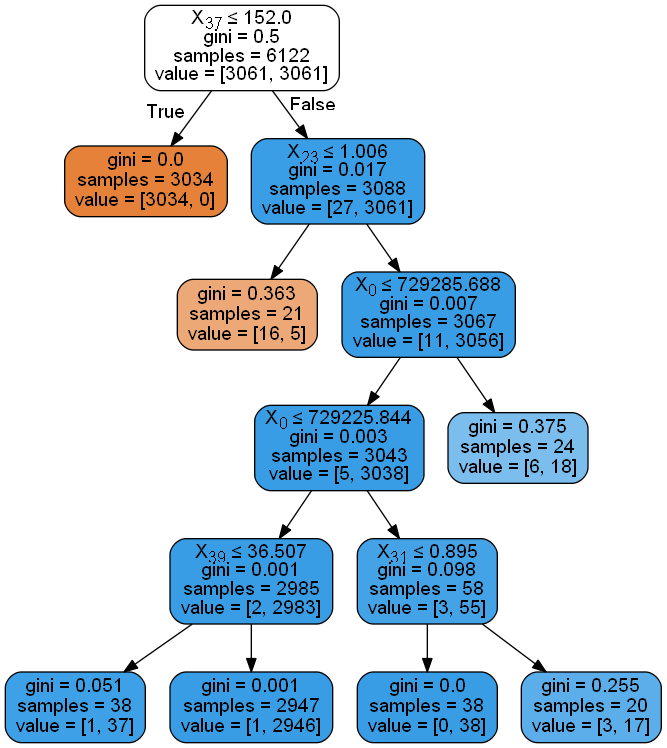

In [55]:
dibu_arb(clf_treeX1)

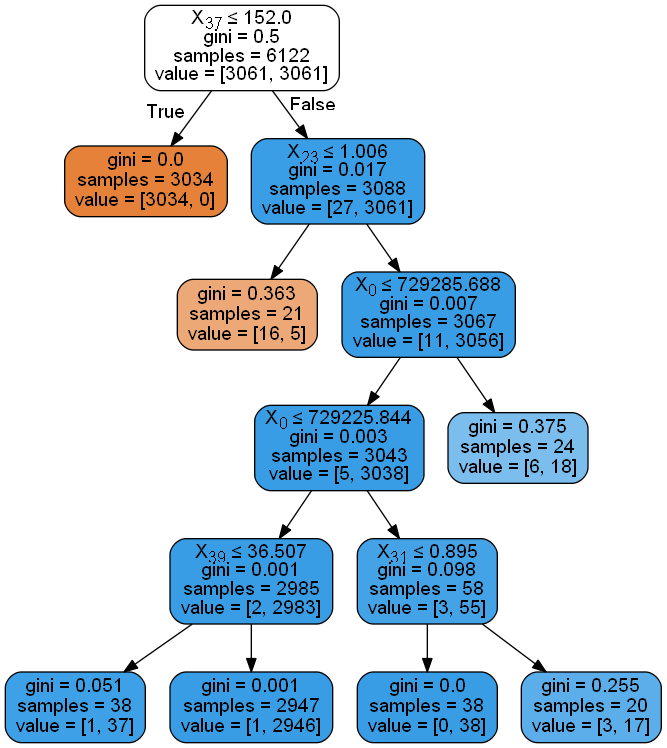

In [56]:
dibu_arb(clf_tree_osX1)

In [57]:
X1_train.columns[8]

'Ord_Loan_Payment'

In [58]:
#El modelo continua dando unos resultados espectaculares, vamos a ver que sucede si eliminamos la variable 'Ord_Loan_Payment'

In [59]:
X2=X1.drop(['Ord_Loan_Payment'], axis=1)

In [60]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.2, random_state=0)

In [61]:
clf_treeX2=clf_tree.fit(X2_train,y2_train)

In [62]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(44,57),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X2,os_y2=smo.fit_sample(X2_train, y2_train)
columns = X2_train.columns
os_X2 = pd.DataFrame(data=os_X2,columns=columns)
os_y2= pd.DataFrame(data=os_y2,columns=['account_loan_bin'])

In [63]:
clf_tree_osX2=clf_tree.fit(os_X2,os_y2)

In [64]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX2,X2_train,y2_train, X2_test, y2_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX2,os_X2,os_y2, X2_test, y2_test)

Sin Oversampling
Datos de train:
El accuracy es 99.55555555555556 %
La precision es 97.9816513761468 %
El recall es 99.07235621521335 %
tn: 3050  fp: 11  fn: 5  tp: 534
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140
Con Oversampling
Datos de train:
El accuracy es 99.73864750081673 %
La precision es 99.64134333224649 %
El recall es 99.83665468801046 %
tn: 3050  fp: 11  fn: 5  tp: 3056
Datos de test:
El accuracy es 99.22222222222223 %
La precision es 97.22222222222221 %
El recall es 97.9020979020979 %
tn: 753  fp: 4  fn: 3  tp: 140


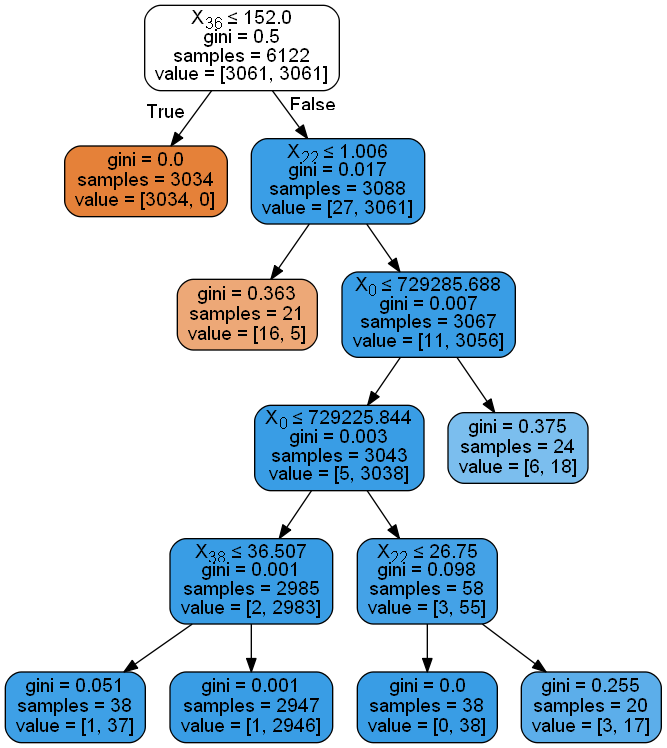

In [65]:
dibu_arb(clf_treeX2)

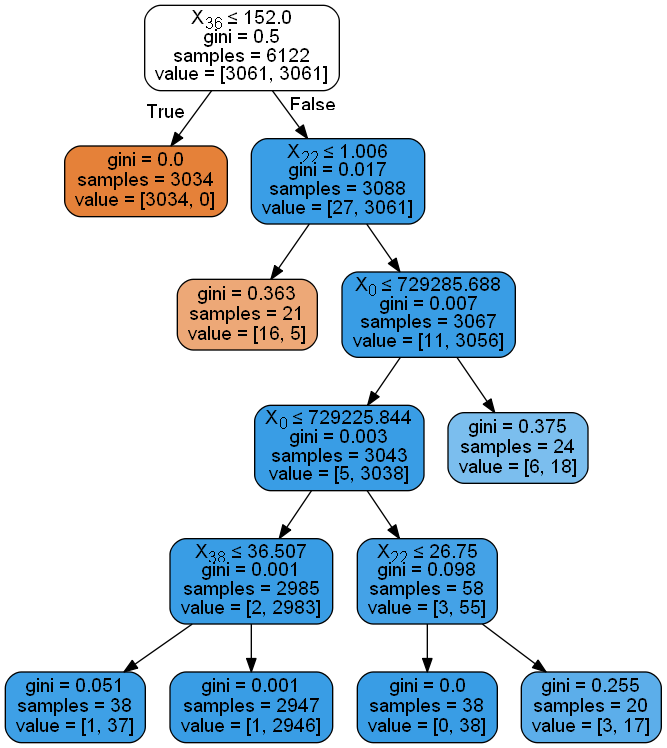

In [66]:
dibu_arb(clf_tree_osX2)

In [67]:
X2_train.columns[36]

'Ord_Loan_Payment_amount'

In [68]:
#El modelo continua dando resultados espectaculares, vamos a ver que sucede si eliminamos la variable Ord_Loan_Payment_amount

In [69]:
X3=X2.drop(['Ord_Loan_Payment_amount'], axis=1)

In [70]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y, test_size=0.2, random_state=0)

In [71]:
clf_treeX3=clf_tree.fit(X3_train,y3_train)

In [72]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(43,56),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X3,os_y3=smo.fit_sample(X3_train, y3_train)
columns = X3_train.columns
os_X3 = pd.DataFrame(data=os_X3,columns=columns)
os_y3= pd.DataFrame(data=os_y3,columns=['account_loan_bin'])

In [73]:
clf_tree_osX3=clf_tree.fit(os_X3,os_y3)

In [74]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX3,os_X3,os_y3, X3_test, y3_test)

Sin Oversampling
Datos de train:
El accuracy es 92.13888888888889 %
La precision es 73.44322344322345 %
El recall es 74.39703153988869 %
tn: 2916  fp: 145  fn: 138  tp: 401
Datos de test:
El accuracy es 89.55555555555556 %
La precision es 66.66666666666666 %
El recall es 68.53146853146853 %
tn: 708  fp: 49  fn: 45  tp: 98
Con Oversampling
Datos de train:
El accuracy es 92.1920940868997 %
La precision es 94.95301079011486 %
El recall es 89.12120222149625 %
tn: 2916  fp: 145  fn: 333  tp: 2728
Datos de test:
El accuracy es 89.55555555555556 %
La precision es 66.66666666666666 %
El recall es 68.53146853146853 %
tn: 708  fp: 49  fn: 45  tp: 98


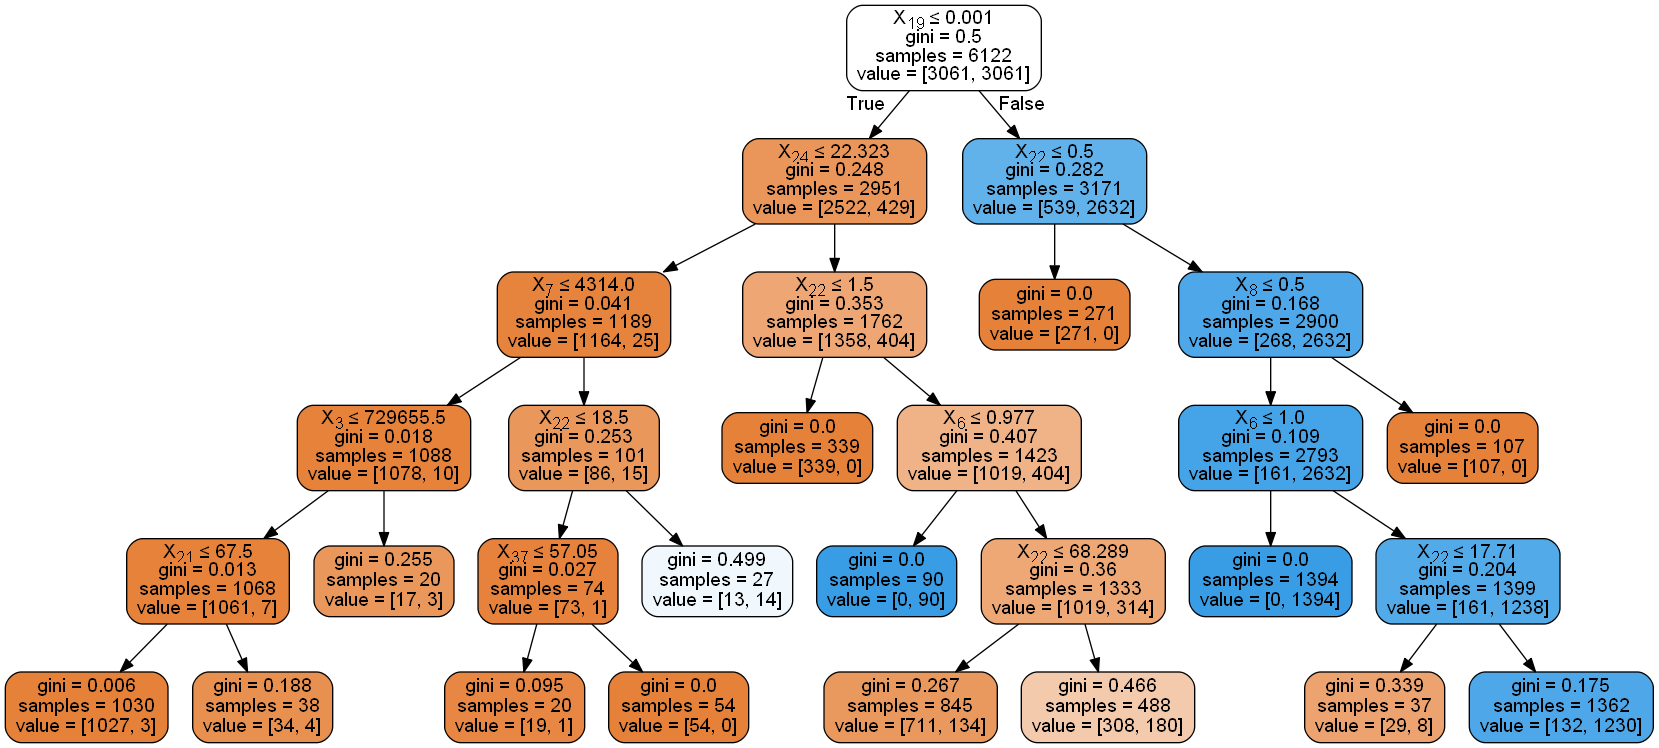

In [75]:
dibu_arb(clf_treeX3)

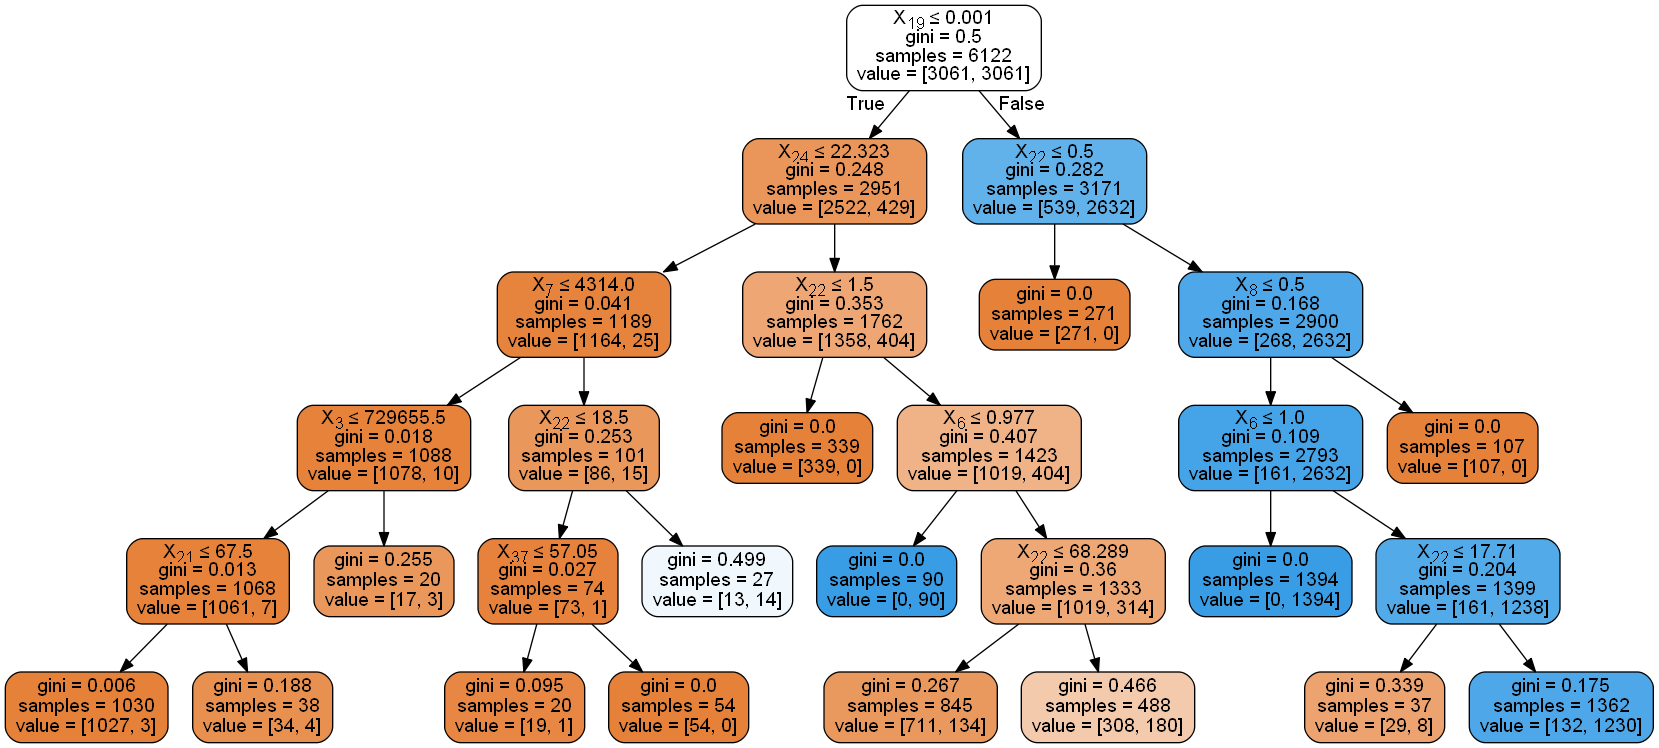

In [76]:
dibu_arb(clf_tree_osX3)

In [77]:
#Vemos cuales son las variables más relevantes
print(X3_train.columns[19])#Número de un tipo especial de reintegros
print(X3_train.columns[24])#Número de ingresos en efectivo
print(X3_train.columns[22])#Número de transferencias enviadas
print(X3_train.columns[6])#Número de pagos relacionados con el hogar
print(X3_train.columns[7])#Importe de pagos relacionados con el hogar
print(X3_train.columns[8])#Número de pagos por Leasing

Num_Type_VYBER
Num_Op_CashCredit
Num_Op_Remittances
Ord_Household_Payment
Ord_Household_Payment_amount
Ord_Leasing


In [78]:
#Vemos las correlaciones de estas variables con la tenencia de préstamo
print(np.corrcoef(df_original["account_loan_bin"],df_original["Num_Type_VYBER"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Num_Op_CashCredit"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Num_Op_Remittances"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Household_Payment"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Household_Payment_amount"]))
print(np.corrcoef(df_original["account_loan_bin"],df_original["Ord_Leasing"]))


[[1.         0.28989446]
 [0.28989446 1.        ]]
[[1.         0.10026035]
 [0.10026035 1.        ]]
[[1.         0.13851467]
 [0.13851467 1.        ]]
[[ 1.         -0.11510295]
 [-0.11510295  1.        ]]
[[1.         0.06508002]
 [0.06508002 1.        ]]
[[ 1.         -0.12101995]
 [-0.12101995  1.        ]]


In [79]:
#Vemos cuales son las variables más relevantes (de otra forma). Coincide con el análisis anterior
clf_treeX3.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.47692636e-04,
       0.00000000e+00, 0.00000000e+00, 5.03630023e-02, 1.54406782e-03,
       7.87652632e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.16672318e-01,
       0.00000000e+00, 3.30428828e-04, 2.25444137e-01, 0.00000000e+00,
       2.65016868e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 3.14036522e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [80]:
clf_tree_osX3.feature_importances_==clf_treeX3.feature_importances_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [81]:
#Chequeamos las variables más relevantes
X3_train.columns[clf_tree_osX3.feature_importances_>0.01]

Index(['Ord_Household_Payment', 'Ord_Leasing', 'Num_Type_VYBER',
       'Num_Op_Remittances', 'Num_Op_CashCredit'],
      dtype='object')

In [82]:
print(df_original.corr()["account_loan_bin"])

Unnamed: 0                      0.003331
district_id                     0.003010
account_id                      0.555004
Date_Account                    0.015261
client_id_owner                 0.556641
client_id_disponent             0.666977
birth_owner                     0.104253
birth_disponent                 0.021728
loan_id                              NaN
Date_Loan                       1.000000
Amount_Loan                          NaN
Duration_Loan                        NaN
Payments_Loan                        NaN
Ord_Insurance                   0.064054
Ord_Insurance_amount            0.066203
Ord_Household_Payment          -0.115103
Ord_Household_Payment_amount    0.065080
Ord_Loan_Payment                0.970807
Ord_Loan_Payment_amount         0.831433
Ord_Leasing                    -0.121020
Ord_Leasing_amount             -0.105988
Ord_Empty                       0.076714
Ord_Empty_amount                0.098316
owner_card_type                 0.033378
disponent_card_t

In [83]:
#Después de eliminar las variables que más suenan a "préstamo", vamos a ver que sucede si eliminamos la variable Num_Type_VYBER.
#Esta variable se corresponde con un tipo especial de reintegros

In [84]:
X4=X3.drop(['Num_Type_VYBER'], axis=1)

In [85]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y, test_size=0.2, random_state=0)

In [86]:
clf_treeX4=clf_tree.fit(X4_train,y4_train)

In [87]:
#Aplicamos oversampling
smo=SMOTENC(categorical_features=range(42,55),random_state=0)# Modificamos rango porque hemos eliminado una variable
os_X4,os_y4=smo.fit_sample(X4_train, y4_train)
columns = X4_train.columns
os_X4 = pd.DataFrame(data=os_X4,columns=columns)
os_y4= pd.DataFrame(data=os_y4,columns=['account_loan_bin'])

In [88]:
clf_tree_osX4=clf_tree.fit(os_X4,os_y4)

In [89]:
#Evaluamos los modelos
print("Sin Oversampling")
eval_modelo(clf_treeX4,X4_train,y4_train, X4_test, y4_test)
print("Con Oversampling")
eval_modelo(clf_tree_osX4,os_X4,os_y4, X4_test, y4_test)

Sin Oversampling
Datos de train:
El accuracy es 84.66666666666667 %
La precision es 49.19454770755886 %
El recall es 73.65491651205936 %
tn: 2651  fp: 410  fn: 142  tp: 397
Datos de test:
El accuracy es 83.55555555555556 %
La precision es 48.78048780487805 %
El recall es 69.93006993006993 %
tn: 652  fp: 105  fn: 43  tp: 100
Con Oversampling
Datos de train:
El accuracy es 86.0829794184907 %
La precision es 86.4641795972268 %
El recall es 85.56027442012414 %
tn: 2651  fp: 410  fn: 442  tp: 2619
Datos de test:
El accuracy es 83.55555555555556 %
La precision es 48.78048780487805 %
El recall es 69.93006993006993 %
tn: 652  fp: 105  fn: 43  tp: 100


# ¿La precision parece que sea al azar?. No estamos overfitteando porque el Oversampling que estamos haciendo precisamente mejora la precision en train

# ¿Puedo considerar que el oversampling no me está aportando nada?

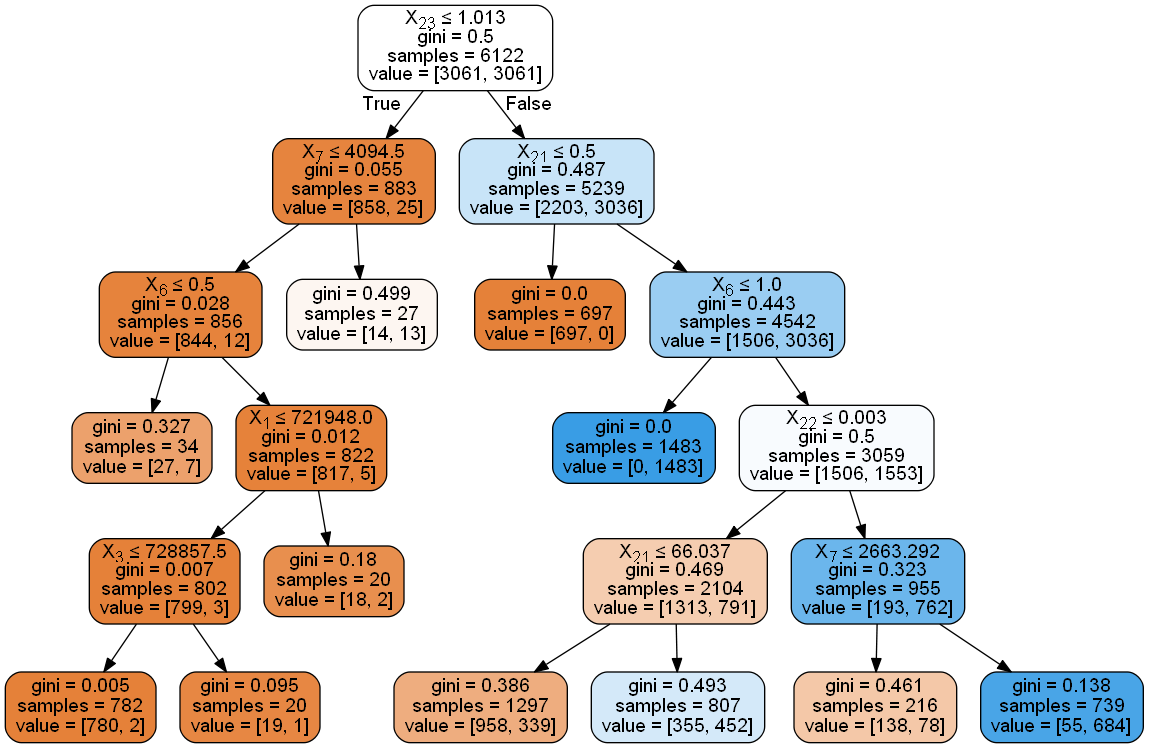

In [90]:
dibu_arb(clf_tree_osX4)

In [91]:
print(X4_train.columns[23])#Número de un tipo especial de reintegros
print(X4_train.columns[7])#Número de ingresos en efectivo
print(X4_train.columns[21])#Número de transferencias enviadas
print(X4_train.columns[6])#Número de pagos relacionados con el hogar
print(X4_train.columns[22])#Importe de pagos relacionados con el hogar
print(X4_train.columns[10])#Número de pagos por Leasing

#Las variables que seguimos obteniendo como más relevantes son muy similares a las del caso anterior

Num_Op_CashCredit
Ord_Household_Payment_amount
Num_Op_Remittances
Ord_Household_Payment
Num_Op_Collection
Ord_Empty_amount


# Me quedo con el DataSet X3 no elimino la variable Num_Type_VYBER

# Las variables que me están saliendo como significativas no parecen aportar mucho

# Vamos a hacer scaling y a ver como cambia el modelo.

In [92]:
#Vamos a probar Robust Scaling
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler()
columns = X3.columns
X3_scale = rbs.fit_transform(X3)
X=pd.DataFrame(X3_scale,columns=columns)

In [93]:
X.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,-0.534615,0.468801,0.0,0.0,0.0,0.0,0.0,0.908203,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.120192,-0.268345,0.0,0.0,0.0,0.0,0.0,-0.115195,0.0,0.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.222115,0.613502,0.0,0.0,1.0,528.0,0.0,-0.483687,0.0,1.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.544231,0.429993,0.0,0.0,0.0,0.0,0.0,-0.076543,0.0,2.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.635577,-0.568076,0.0,0.0,0.0,0.0,0.0,0.087183,0.0,0.0,...,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
X.shape

(4500, 56)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [96]:
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [97]:
clf_treeX3=clf_tree.fit(X3_train,y3_train)

In [98]:
#Comparamos los modelos con y sin scaling
print("Sin Scaling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Scaling")
eval_modelo(clf_tree,X_train,y_train, X_test, y_test)

Sin Scaling
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.33333333333333 %
La precision es 84.21052631578947 %
El recall es 55.94405594405595 %
tn: 742  fp: 15  fn: 63  tp: 80
Con Scaling
Datos de train:
El accuracy es 87.13888888888889 %
La precision es 69.38775510204081 %
El recall es 25.231910946196663 %
tn: 3001  fp: 60  fn: 403  tp: 136
Datos de test:
El accuracy es 85.88888888888889 %
La precision es 64.81481481481481 %
El recall es 24.475524475524477 %
tn: 738  fp: 19  fn: 108  tp: 35


In [99]:
# Los resultados con Robust Scaling no mejoran los resultados previos al scaling. El modelo con Robust Scaling tiende a generar 
#menos positivos que el modelo sin scaling, así que vamos a probar con Standard Scaling

In [100]:
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
columns = X3.columns
X3_scale = scl.fit_transform(X3)
X=pd.DataFrame(X3_scale,columns=columns)
X.shape

C:\Users\osmaa\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\osmaa\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


(4500, 56)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [102]:
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [103]:
clf_treeX3=clf_tree.fit(X3_train,y3_train)

In [104]:
#Comparamos los modelos con y sin scaling
print("Sin Scaling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Scaling")
eval_modelo(clf_tree,X_train,y_train, X_test, y_test)

Sin Scaling
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.33333333333333 %
La precision es 84.21052631578947 %
El recall es 55.94405594405595 %
tn: 742  fp: 15  fn: 63  tp: 80
Con Scaling
Datos de train:
El accuracy es 86.36111111111111 %
La precision es 71.05263157894737 %
El recall es 15.0278293135436 %
tn: 3028  fp: 33  fn: 458  tp: 81
Datos de test:
El accuracy es 85.77777777777777 %
La precision es 68.29268292682927 %
El recall es 19.58041958041958 %
tn: 744  fp: 13  fn: 115  tp: 28


In [105]:
#En este caso, el standard scaling tiende a generar menos positivos que el modelo sin scaling
#Standard Scaling tampoco ha funcionado mejor que sin scaling. Aplicamos scaling sólo a las variables numéricas
print(X3.columns)
print(X3.shape)

Index(['Date_Account', 'birth_owner', 'birth_disponent', 'owner_card_date',
       'Ord_Insurance', 'Ord_Insurance_amount', 'Ord_Household_Payment',
       'Ord_Household_Payment_amount', 'Ord_Leasing', 'Ord_Empty',
       'Ord_Empty_amount', 'num_inhabitants', 'municip < 499',
       'municip 500-1999', 'municip 2000-9999', 'municip > 10000',
       'num_cities', 'avg_salary', 'Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
       'Num_Op_Collection', 'Num_Op_CashCredit', 'Num_Op_WithdrawalCash',
       'Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
       'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Balance_in_negative', 'Ord_Leasing_amount', 'ratio_urban_inhabitants',
       'unemployment_rate_95', 'unemployment_rate_96', 'crimes_95_ratio',
       'crimes_96_ratio', 'entrepreneurs_ratio', 'account_disponent_bin_0',
       'a

In [106]:
#Separamos las variables numéricas de las que consideramos categóricas
X3_cat=X3[['account_disponent_bin_0','account_disponent_bin_1',
       'frequency_After_trans', 'frequency_Monthly', 'frequency_Weekly',
       'sex_owner_F', 'sex_owner_M', 'owner_card_type_0', 'owner_card_type_1',
       'owner_card_type_2', 'owner_card_type_3', 'sex_disponent_F',
       'sex_disponent_M']]
X3_num=X3[['Date_Account', 'birth_owner', 'birth_disponent', 'owner_card_date',
       'Ord_Insurance', 'Ord_Insurance_amount', 'Ord_Household_Payment',
       'Ord_Household_Payment_amount', 'Ord_Leasing', 'Ord_Empty',
       'Ord_Empty_amount', 'num_inhabitants', 'municip < 499',
       'municip 500-1999', 'municip 2000-9999', 'municip > 10000',
       'num_cities', 'avg_salary', 'Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
       'Num_Op_Collection', 'Num_Op_CashCredit', 'Num_Op_WithdrawalCash',
       'Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
       'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Balance_in_negative', 'Ord_Leasing_amount', 'ratio_urban_inhabitants',
       'unemployment_rate_95', 'unemployment_rate_96', 'crimes_95_ratio',
       'crimes_96_ratio', 'entrepreneurs_ratio']]

In [107]:
#Probamos con el Robust Scaling
columns = X3_num.columns
X3_scale = rbs.fit_transform(X3_num)
X3_scale=pd.DataFrame(X3_scale,columns=columns)
X = pd.concat([X3_scale,X3_cat], axis = 1)
X.shape

(4500, 56)

In [108]:
X.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,-0.534615,0.468801,0.0,0.0,0.0,0.0,0.0,0.908203,1.0,0.0,...,1,0,0,1,1,0,0,0,0,0
1,-0.120192,-0.268345,0.0,0.0,0.0,0.0,0.0,-0.115195,0.0,0.0,...,1,0,1,0,1,0,0,0,0,0
2,0.222115,0.613502,0.0,0.0,1.0,528.0,0.0,-0.483687,0.0,1.0,...,1,0,1,0,1,0,0,0,0,0
3,0.544231,0.429993,0.0,0.0,0.0,0.0,0.0,-0.076543,0.0,2.0,...,1,0,1,0,1,0,0,0,0,0
4,-0.635577,-0.568076,0.0,0.0,0.0,0.0,0.0,0.087183,0.0,0.0,...,1,0,1,0,1,0,0,0,0,0


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [110]:
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [111]:
clf_treeX3=clf_tree.fit(X3_train,y3_train)

In [112]:
#Comparamos los modelos con y sin scaling
print("Sin Scaling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Robust Scaling")
eval_modelo(clf_tree,X_train,y_train, X_test, y_test)

Sin Scaling
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.22222222222223 %
La precision es 83.33333333333334 %
El recall es 55.94405594405595 %
tn: 741  fp: 16  fn: 63  tp: 80
Con Robust Scaling
Datos de train:
El accuracy es 87.13888888888889 %
La precision es 69.38775510204081 %
El recall es 25.231910946196663 %
tn: 3001  fp: 60  fn: 403  tp: 136
Datos de test:
El accuracy es 85.88888888888889 %
La precision es 64.81481481481481 %
El recall es 24.475524475524477 %
tn: 738  fp: 19  fn: 108  tp: 35


In [113]:
#En este caso, el robust scaling tiende a generar menos positivos que el modelo sin scaling

In [114]:
#Probamos con min-max scaling
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()

In [115]:
columns = X3_num.columns
X3_scale = minmax.fit_transform(X3_num)
X3_scale=pd.DataFrame(X3_scale,columns=columns)
X = pd.concat([X3_scale,X3_cat], axis = 1)
X.shape

C:\Users\osmaa\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


(4500, 56)

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [117]:
clf_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [118]:
clf_treeX3=clf_tree.fit(X3_train,y3_train)

In [119]:
#Comparamos los modelos con y sin scaling
print("Sin Scaling")
eval_modelo(clf_treeX3,X3_train,y3_train, X3_test, y3_test)
print("Con Scaling")
eval_modelo(clf_tree,X_train,y_train, X_test, y_test)

Sin Scaling
Datos de train:
El accuracy es 92.5 %
La precision es 86.25336927223721 %
El recall es 59.36920222634509 %
tn: 3010  fp: 51  fn: 219  tp: 320
Datos de test:
El accuracy es 91.33333333333333 %
La precision es 84.21052631578947 %
El recall es 55.94405594405595 %
tn: 742  fp: 15  fn: 63  tp: 80
Con Scaling
Datos de train:
El accuracy es 85.0 %
La precision es 44.44444444444444 %
El recall es 0.7421150278293136 %
tn: 3056  fp: 5  fn: 535  tp: 4
Datos de test:
El accuracy es 83.66666666666667 %
La precision es 0.0 %
El recall es 0.0 %
tn: 753  fp: 4  fn: 143  tp: 0


In [120]:
#Con scaling MinMax el modelo casi no genera predicciones positivas y el accuracy se obtiene por un modelo que básicamente
#predice en test que la cuenta no contrata préstamo

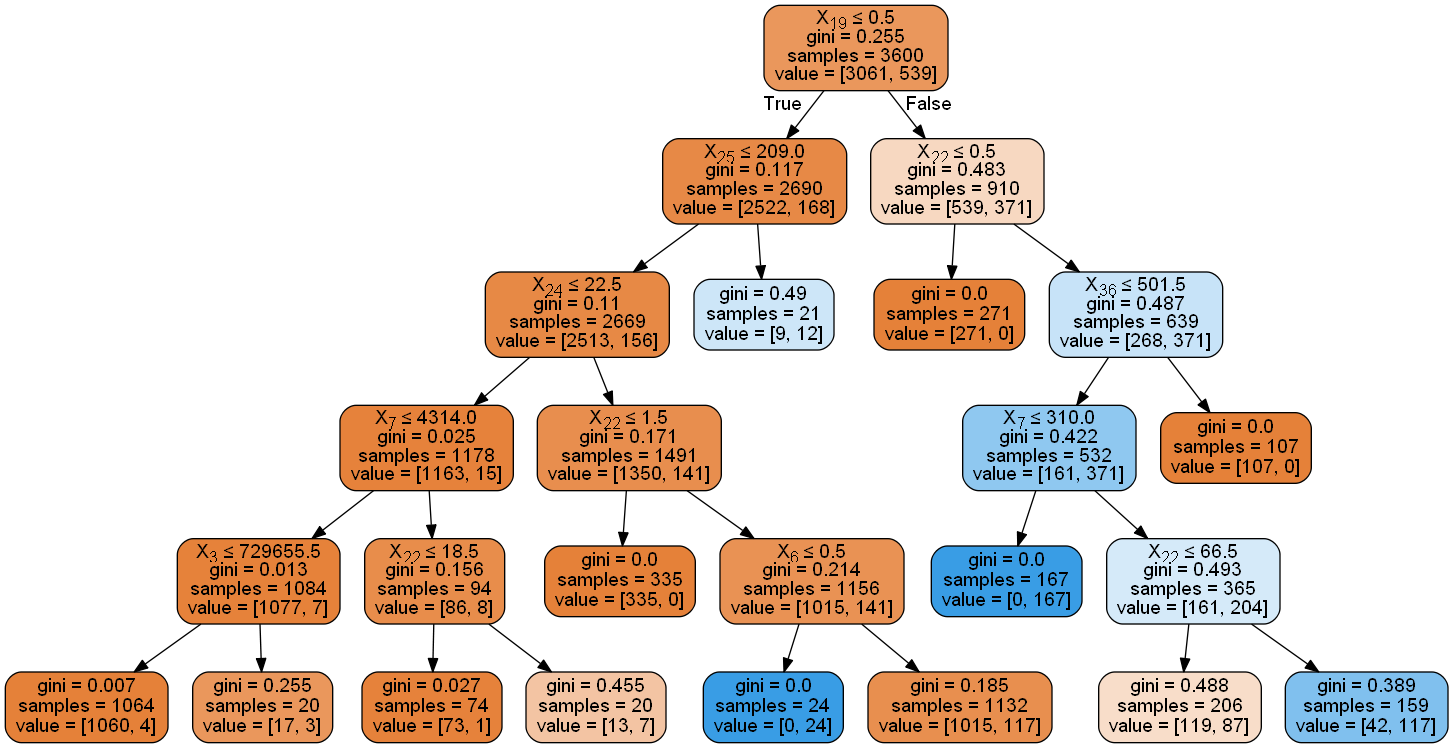

In [121]:
dibu_arb(clf_tree)

# Hasta el momento hemos visto que en el dataset que habíamos generado 
habían 3 variables que "contenían" la información de la variable que queríamos predecir y también hemos visto que, en el caso de Decission Trees, las técnicas de Oversampling y de Scaling tal y como las hemos aplicado no mejoran los modelos iniciales.
Disponemos también de una primera pista sobre cuales podrían ser las variables más relevantes para la contratación de préstamos

# A continuación trabajamos sobre las features numéricas

In [122]:
print(X3_num.columns)

Index(['Date_Account', 'birth_owner', 'birth_disponent', 'owner_card_date',
       'Ord_Insurance', 'Ord_Insurance_amount', 'Ord_Household_Payment',
       'Ord_Household_Payment_amount', 'Ord_Leasing', 'Ord_Empty',
       'Ord_Empty_amount', 'num_inhabitants', 'municip < 499',
       'municip 500-1999', 'municip 2000-9999', 'municip > 10000',
       'num_cities', 'avg_salary', 'Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances',
       'Num_Op_Collection', 'Num_Op_CashCredit', 'Num_Op_WithdrawalCash',
       'Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal',
       'Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Balance_in_negative', 'Ord_Leasing_amount', 'ratio_urban_inhabitants',
       'unemployment_rate_95', 'unemployment_rate_96', 'crimes_95_ratio',
       'crimes_96_ratio', 'entrepreneurs_ratio'],
      dtype='object')


In [123]:
#A partir del DataFrame X3 creamos un DataFrame que contenga el log natural de las variables numéricas
cols = X3_num.columns
X3_log=pd.DataFrame(X3_num,columns=columns)# Tambien podríamos hacer un copy del DF

In [124]:
#Calculamos el logaritmo de las variables que consideramos numéricas
cols=X3_num.columns
for col in cols:
    X3_log[col]=X3_log[col]+1.1 #Para evitar errores al aplicar el logaritmo
    X3_log[col]=np.log(X3_log[col])

In [125]:
X3_log.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,Num_Sym_Statement,Num_Sym_IntDep,Balance_in_negative,Ord_Leasing_amount,ratio_urban_inhabitants,unemployment_rate_95,unemployment_rate_96,crimes_95_ratio,crimes_96_ratio,entrepreneurs_ratio
0,13.498201,13.484813,0.741937,0.741937,0.095310,0.095310,0.741937,8.801936,0.741937,0.095310,...,3.914021,4.009150,0.09531,6.375195,4.61611,0.329304,0.425268,0.157947,0.167419,0.095436
1,13.498792,13.474528,0.741937,0.741937,0.095310,0.095310,0.741937,7.567397,0.095310,0.095310,...,3.586293,3.613617,0.09531,0.095310,4.61611,0.329304,0.425268,0.157947,0.167419,0.095436
2,13.499281,13.486819,0.741937,0.741937,0.741937,6.271177,0.741937,5.468482,0.095310,0.741937,...,3.182212,3.370738,0.09531,0.095310,4.61611,0.329304,0.425268,0.157947,0.167419,0.095436
3,13.499740,13.484274,0.741937,0.741937,0.095310,0.095310,0.741937,7.655438,0.095310,1.131402,...,2.572612,2.895912,0.09531,0.095310,4.61611,0.329304,0.425268,0.157947,0.167419,0.095436
4,13.498056,13.470315,0.741937,0.741937,0.095310,0.095310,0.741937,7.960707,0.095310,0.095310,...,3.972177,3.990834,0.09531,0.095310,4.61611,0.329304,0.425268,0.157947,0.167419,0.095436


In [126]:
#Creamos un DataFrame a partir del DataFrame X3 (una vez eliminadas las 3 variables que conteníanla información de la variable
#dependiente), aplicando logaritmo a las variables que consideramos numéricas y dejando las categóricas igual.
X_log= pd.concat([X3_log,X3_cat], axis = 1)

In [127]:
X_log.head()

,Date_Account,birth_owner,birth_disponent,owner_card_date,Ord_Insurance,Ord_Insurance_amount,Ord_Household_Payment,Ord_Household_Payment_amount,Ord_Leasing,Ord_Empty,...,frequency_Monthly,frequency_Weekly,sex_owner_F,sex_owner_M,owner_card_type_0,owner_card_type_1,owner_card_type_2,owner_card_type_3,sex_disponent_F,sex_disponent_M
0,13.498201,13.484813,0.741937,0.741937,0.095310,0.095310,0.741937,8.801936,0.741937,0.095310,...,1,0,0,1,1,0,0,0,0,0
1,13.498792,13.474528,0.741937,0.741937,0.095310,0.095310,0.741937,7.567397,0.095310,0.095310,...,1,0,1,0,1,0,0,0,0,0
2,13.499281,13.486819,0.741937,0.741937,0.741937,6.271177,0.741937,5.468482,0.095310,0.741937,...,1,0,1,0,1,0,0,0,0,0
3,13.499740,13.484274,0.741937,0.741937,0.095310,0.095310,0.741937,7.655438,0.095310,1.131402,...,1,0,1,0,1,0,0,0,0,0
4,13.498056,13.470315,0.741937,0.741937,0.095310,0.095310,0.741937,7.960707,0.095310,0.095310,...,1,0,1,0,1,0,0,0,0,0


In [128]:
#Vamos a crear un nuevo DataFrame binarizando las variables que tienen el número de operaciones (pasan de tener el número de 
#operaciones a decir si la cuenta ha realizado ese tipo de operativa o no) y eliminando las columnas que contienen
#el sufijo "_amount" (sólo queremos reflejar si se ha realizado un tipo de operativa o no se ha realizado)

col_to_bin=['Ord_Insurance', 'Ord_Household_Payment','Ord_Leasing', 'Ord_Empty','Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances','Num_Op_Collection', 'Num_Op_CashCredit', 
       'Num_Op_WithdrawalCash','Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal','Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Balance_in_negative']

col_out=['Ord_Insurance_amount','Ord_Household_Payment_amount','Ord_Empty_amount', 'Ord_Leasing_amount']

In [129]:
cols = X3.columns
X3_bin=pd.DataFrame(X3,columns=cols)
X3_bin=X3_bin.drop(col_out, axis=1)#Eliminamos las columnas de amount
X3_bin=X3_bin.drop(col_to_bin, axis=1)#Eliminamos las columnas a binarizar

In [130]:
X3_bin.shape

(4500, 30)

In [131]:
#Definimos el dataset que queremos binarizar
X3_to_bin=X3[['Ord_Insurance', 'Ord_Household_Payment','Ord_Leasing', 'Ord_Empty','Num_Type_Credit', 'Num_Type_VYBER',
       'Num_Type_Withdrawal', 'Num_Op_Null', 'Num_Op_Remittances','Num_Op_Collection', 'Num_Op_CashCredit', 
       'Num_Op_WithdrawalCash','Num_Op_WithdrawalCreditCard', 'Num_Sym_Null', 'Num_Sym_Null2',
       'Num_Sym_Pension', 'Num_Sym_Insurance', 'Num_Sym_NegBal','Num_Sym_Household', 'Num_Sym_Statement', 'Num_Sym_IntDep',
       'Balance_in_negative']]

In [132]:
def binario(x):
    if x>0:
        x=1
    else:
        x=0
    return x

In [133]:
for col in col_to_bin:
    X3_to_bin[col]=X3_to_bin[col].apply(binario)

C:\Users\osmaa\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [134]:
X3_to_bin=X3_to_bin.astype(str)
X3_to_bin=pd.get_dummies(X3_to_bin)

# ¿Porque hay algunas columnas que no se duplican con el get_dummies?

In [135]:
#Creamos un DataFrame a partir del DataFrame X3 (una vez eliminadas las 3 variables que conteníanla información de la variable
#dependiente), binarizando las variables que contaban el número de operaciones.
X_bin= pd.concat([X3_bin,X3_to_bin], axis = 1)

In [136]:
X_bin.shape

(4500, 69)

In [137]:
df_original.head()

,Unnamed: 0,district_id,account_id,frequency,Date_Account,client_id_owner,client_id_disponent,sex_owner,birth_owner,sex_disponent,...,Num_Sym_Pension,Num_Sym_Insurance,Num_Sym_NegBal,Num_Sym_Household,Num_Sym_Statement,Num_Sym_IntDep,Num_Sym_LoanPayment,Balance_in_negative,account_disponent_bin,account_loan_bin
0,1,1,1938,Monthly,728104,2354,NaN,M,718421,NaN,...,0,0,0,50,49,54,0,0,0,0
1,2,1,1562,Monthly,728535,1894,NaN,F,711070,NaN,...,0,0,0,36,35,36,0,0,0,0
2,3,1,7099,Monthly,728891,8568,NaN,F,719864,NaN,...,0,24,0,24,23,28,7,0,0,1
3,4,1,2316,Monthly,729226,2802,NaN,F,718034,NaN,...,0,0,0,13,12,17,0,0,0,0
4,5,1,1570,Monthly,727999,1903,NaN,F,708081,NaN,...,57,0,0,53,52,53,0,0,0,0


# Con los nuevos DataFrames de features vamos a intentar encontrar el mejor Decision Tree y ver cuales son las variables más significativas 

In [173]:
#Los DataFrames con los que vamos a trabajar son:
#X_orig: El Dataframe con el que habíamos trabajado antes eliminando 3 variables, también lo llamábamos X3.
X=X3
#X_log: Es el Dataframe X_orig pero haciendo el logaritmo natural a las variables numéricas
#X_bin: Es el Dataframe X_orig pero binarizando las variables que contaban cuantas operaciones de cada tipo se habían realizado
#en cada cuenta, ahora decimos si la cuenta tiene ese tipo de operativa o no, y eliminando las variables que cuantificaban los
#importes de dicha operativa

In [141]:
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#Inicialmente pensaba considerar como métrica la precisión (quería que el modelo minimizase los falsos positivos,
#pero en vista de los resultados de los modelos anteriores, en los que el recall (el % de positivos que acierto) 
#puede ser muy bajo voy a comenzar a monitorizar también el F1 Score 

In [202]:
def eval_modelo_2 (clf,X_train,y_train, X_test,y_test):
    print("Datos de train:")
    print("El accuracy es",accuracy_score(y_train,clf.predict(X_train))*100,"%")
    print("La precision es",precision_score(y_train,clf.predict(X_train))*100, "%")
    print("El recall es",recall_score(y_train,clf.predict(X_train))*100, "%")
    print("El F1 Score es",f1_score(y_train,clf.predict(X_train))*100,"%")
    tn, fp, fn, tp=confusion_matrix(y_train,clf.predict(X_train)).ravel()
    print("tn:",tn," fp:",fp," fn:",fn," tp:",tp)
    print("Datos de test:")
    print("El accuracy es",accuracy_score(y_test,clf.predict(X_test))*100,"%")
    print("La precision es",precision_score(y_test,clf.predict(X_test))*100, "%")
    print("El recall es",recall_score(y_test,clf.predict(X_test))*100,"%")
    print("El F1 Score es",f1_score(y_test,clf.predict(X_test))*100,"%")
    tn_t, fp_t, fn_t, tp_t=confusion_matrix(y_test,clf.predict(X_test)).ravel()
    print("tn:",tn_t," fp:",fp_t," fn:",fn_t," tp:",tp_t)      

In [180]:
#Vamos a definir la parrilla para realizar Randomized Grid Search

# Máximo número de niveles en el árbol. Damos una distribución con mayor probabilidad en valores pequeños
max_depth1 = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth2 =[int(x) for x in np.linspace(30, 100, num = 4)]
max_depth=max_depth1 + max_depth2
#max_depth.append(None)

# Mínimo número de observaciones en cada hoja.Damos una distribución con mayor probabilidad en valores pequeños
min_samples_leaf_1 = [int(x) for x in np.linspace(5, 50, num = 10)]
min_samples_leaf_2 = [int(x) for x in np.linspace(60, 100, num = 5)]
min_samples_leaf=min_samples_leaf_1+min_samples_leaf_2
#min_samples_leaf.append(None)

In [181]:
# Creamos la grid aleatoria
random_grid = {'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               }

In [199]:
clf_tree = DecisionTreeClassifier()
clf_tree_random_p= RandomizedSearchCV(estimator = clf_tree, param_distributions = random_grid, n_iter = 100, cv = 5,scoring="precision")
clf_tree_random_f1= RandomizedSearchCV(estimator = clf_tree, param_distributions = random_grid, n_iter = 100, cv = 5,scoring="f1")

In [192]:
#Comenzamos por el DataFrame X
#Generamos conjuntos de train y de test. Para el test usamos el 20% de las observaciones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [194]:
clf_tree_random_p.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 30, 53, 76, 100], 'min_samples_leaf': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='precision', verbose=0)

In [195]:
print("tuned hpyerparameters :(best parameters) ",clf_tree_random_p.best_params_)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 20, 'max_depth': 8}


In [196]:
clf_tree_p = clf_tree_random_p.best_estimator_  
clf_tree_p.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [197]:
eval_modelo_2 (clf_tree_p,X_train,y_train, X_test,y_test)

Datos de train:
El accuracy es 94.41666666666667 %
La precision es 89.85849056603774 %
La precision es 89.85849056603774 %
El F1 Score es 79.12772585669782 %
tn: 3018  fp: 43  fn: 158  tp: 381
Datos de test:
El accuracy es 92.55555555555556 %
La precision es 85.18518518518519 %
El recall es 64.33566433566433 %
El F1 Score es 73.30677290836654 %
tn: 741  fp: 16  fn: 51  tp: 92


In [205]:
X.columns[clf_tree_p.feature_importances_>0.10]

Index(['Num_Type_VYBER', 'Num_Op_Remittances', 'Ord_Leasing_amount'], dtype='object')

In [201]:
#Optimizamos ahora el F1 Score

clf_tree_random_f1.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf_tree_random_f1.best_params_)

clf_tree_f1 = clf_tree_random_f1.best_estimator_  
clf_tree_f1.fit(X_train,y_train)

eval_modelo_2 (clf_tree_f1,X_train,y_train, X_test,y_test)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 5, 'max_depth': 14}
Datos de train:
El accuracy es 97.94444444444444 %
La precision es 94.28571428571428 %
La precision es 94.28571428571428 %
El F1 Score es 93.04511278195488 %
tn: 3031  fp: 30  fn: 44  tp: 495
Datos de test:
El accuracy es 93.44444444444444 %
La precision es 83.87096774193549 %
El recall es 72.72727272727273 %
El F1 Score es 77.90262172284645 %
tn: 737  fp: 20  fn: 39  tp: 104


In [206]:
X.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_amount', 'Ord_Leasing', 'Num_Type_VYBER',
       'Num_Op_Remittances'],
      dtype='object')

In [209]:
#Parece que los modelos anteriores overfittean. Vamos a probar un modelo más sencillo
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=3)
clf_tree.fit(X_train,y_train)
eval_modelo_2(clf_tree,X_train,y_train, X_test,y_test)

Datos de train:
El accuracy es 90.94444444444446 %
La precision es 69.25858951175407 %
El recall es 71.05751391465677 %
El F1 Score es 70.14652014652015 %
tn: 2891  fp: 170  fn: 156  tp: 383
Datos de test:
El accuracy es 89.11111111111111 %
La precision es 65.73426573426573 %
El recall es 65.73426573426573 %
El F1 Score es 65.73426573426573 %
tn: 708  fp: 49  fn: 49  tp: 94


In [210]:
X.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_amount', 'Ord_Leasing', 'Num_Type_VYBER',
       'Num_Op_Remittances'],
      dtype='object')

In [218]:
#Comenzamos por el DataFrame X_log
#Generamos conjuntos de train y de test. Para el test usamos el 20% de las observaciones
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log, y, test_size=0.2, random_state=0)

In [219]:
clf_tree_random_p.fit(X_log_train, y_log_train)
print("tuned hpyerparameters :(best parameters) ",clf_tree_random_p.best_params_)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 10, 'max_depth': 30}


In [222]:
clf_tree_p = clf_tree_random_p.best_estimator_  
clf_tree_p.fit(X_log_train,y_log_train)
eval_modelo_2(clf_tree_p,X_log_train, y_log_train,X_log_test, y_log_test)

Datos de train:
El accuracy es 96.38888888888889 %
La precision es 88.8045540796964 %
El recall es 86.82745825602969 %
El F1 Score es 87.8048780487805 %
tn: 3002  fp: 59  fn: 71  tp: 468
Datos de test:
El accuracy es 92.33333333333333 %
La precision es 79.36507936507937 %
El recall es 69.93006993006993 %
El F1 Score es 74.34944237918215 %
tn: 731  fp: 26  fn: 43  tp: 100


In [223]:
X.columns[clf_tree_p.feature_importances_>0.10]

Index(['Ord_Household_Payment_amount', 'Num_Type_VYBER', 'Num_Op_Remittances',
       'Ord_Leasing_amount'],
      dtype='object')

In [224]:
#Optimizamos ahora el F1 Score
clf_tree_random_f1.fit(X_log_train, y_log_train)
print("tuned hpyerparameters :(best parameters) ",clf_tree_random_f1.best_params_)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 5, 'max_depth': 100}


In [225]:
clf_tree_f1 = clf_tree_random_f1.best_estimator_  
clf_tree_f1.fit(X_log_train, y_log_train)
eval_modelo_2 (clf_tree_f1,X_log_train, y_log_train,X_log_test, y_log_test)

Datos de train:
El accuracy es 97.91666666666666 %
La precision es 94.78764478764478 %
El recall es 91.09461966604823 %
El F1 Score es 92.90444654683066 %
tn: 3034  fp: 27  fn: 48  tp: 491
Datos de test:
El accuracy es 93.33333333333333 %
La precision es 82.67716535433071 %
El recall es 73.42657342657343 %
El F1 Score es 77.77777777777779 %
tn: 735  fp: 22  fn: 38  tp: 105


In [226]:
X_log.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_amount', 'Num_Type_VYBER', 'Num_Op_Remittances',
       'Ord_Leasing_amount'],
      dtype='object')

In [227]:
#Parece que los modelos anteriores overfittean. Vamos a probar un modelo más sencillo
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=3)
clf_tree.fit(X_log_train, y_log_train)
eval_modelo_2(clf_tree,X_log_train, y_log_train,X_log_test, y_log_test)

Datos de train:
El accuracy es 90.94444444444446 %
La precision es 69.25858951175407 %
El recall es 71.05751391465677 %
El F1 Score es 70.14652014652015 %
tn: 2891  fp: 170  fn: 156  tp: 383
Datos de test:
El accuracy es 89.11111111111111 %
La precision es 65.73426573426573 %
El recall es 65.73426573426573 %
El F1 Score es 65.73426573426573 %
tn: 708  fp: 49  fn: 49  tp: 94


In [228]:
X_log.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_amount', 'Num_Type_VYBER', 'Num_Op_Remittances',
       'Ord_Leasing_amount'],
      dtype='object')

In [229]:
#Seguimos con el DataFrame X_bin
#Generamos conjuntos de train y de test. Para el test usamos el 20% de las observaciones
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, y, test_size=0.2, random_state=0)

In [230]:
clf_tree_random_p.fit(X_bin_train, y_bin_train)
print("tuned hpyerparameters :(best parameters) ",clf_tree_random_p.best_params_)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 10, 'max_depth': 8}


In [231]:
clf_tree_p = clf_tree_random_p.best_estimator_  
clf_tree_p.fit(X_bin_train,y_bin_train)
eval_modelo_2(clf_tree_p,X_bin_train, y_bin_train,X_bin_test, y_bin_test)

Datos de train:
El accuracy es 92.94444444444444 %
La precision es 85.01228501228502 %
El recall es 64.19294990723562 %
El F1 Score es 73.15010570824525 %
tn: 3000  fp: 61  fn: 193  tp: 346
Datos de test:
El accuracy es 90.0 %
La precision es 77.89473684210526 %
El recall es 51.74825174825175 %
El F1 Score es 62.18487394957983 %
tn: 736  fp: 21  fn: 69  tp: 74


In [233]:
X_bin.columns[clf_tree_p.feature_importances_>0.10]

Index(['Ord_Leasing_0', 'Num_Type_VYBER_0', 'Num_Op_Remittances_0'], dtype='object')

In [234]:
#Optimizamos ahora el F1 Score
clf_tree_random_f1.fit(X_bin_train, y_bin_train)
print("tuned hpyerparameters :(best parameters) ",clf_tree_random_f1.best_params_)

tuned hpyerparameters :(best parameters)  {'min_samples_leaf': 10, 'max_depth': 4}


In [235]:
clf_tree_f1 = clf_tree_random_f1.best_estimator_  
clf_tree_f1.fit(X_bin_train, y_bin_train)
eval_modelo_2 (clf_tree_f1,X_bin_train, y_bin_train,X_bin_test, y_bin_test)

Datos de train:
El accuracy es 91.69444444444444 %
La precision es 71.35231316725978 %
El recall es 74.39703153988869 %
El F1 Score es 72.84287011807447 %
tn: 2900  fp: 161  fn: 138  tp: 401
Datos de test:
El accuracy es 89.77777777777777 %
La precision es 67.3469387755102 %
El recall es 69.23076923076923 %
El F1 Score es 68.27586206896552 %
tn: 709  fp: 48  fn: 44  tp: 99


In [237]:
X_bin.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_1', 'Ord_Leasing_0', 'Num_Type_VYBER_0',
       'Num_Op_Remittances_1'],
      dtype='object')

In [238]:
#Parece que los modelos anteriores overfittean. Vamos a probar un modelo más sencillo
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=3)
clf_tree.fit(X_bin_train, y_bin_train)
eval_modelo_2(clf_tree,X_bin_train, y_bin_train,X_bin_test, y_bin_test)

Datos de train:
El accuracy es 90.86111111111111 %
La precision es 69.73684210526315 %
El recall es 68.83116883116884 %
El F1 Score es 69.28104575163398 %
tn: 2900  fp: 161  fn: 168  tp: 371
Datos de test:
El accuracy es 89.0 %
La precision es 65.71428571428571 %
El recall es 64.33566433566433 %
El F1 Score es 65.01766784452296 %
tn: 709  fp: 48  fn: 51  tp: 92


In [239]:
X_bin.columns[clf_tree_f1.feature_importances_>0.10]

Index(['Ord_Household_Payment_1', 'Ord_Leasing_0', 'Num_Type_VYBER_0',
       'Num_Op_Remittances_1'],
      dtype='object')

# Vamos a probar con Random Forest

In [ ]:
#Vamos a definir la parrilla para realizar Randomized Grid Search

# Máximo número de niveles en el árbol. Damos una distribución con mayor probabilidad en valores pequeños
max_depth1 = [int(x) for x in np.linspace(2, 20, num = 10)]
max_depth2 =[int(x) for x in np.linspace(30, 100, num = 4)]
max_depth=max_depth1 + max_depth2
#max_depth.append(None)

# Mínimo número de observaciones en cada hoja.Damos una distribución con mayor probabilidad en valores pequeños
min_samples_leaf_1 = [int(x) for x in np.linspace(5, 50, num = 10)]
min_samples_leaf_2 = [int(x) for x in np.linspace(60, 100, num = 5)]
min_samples_leaf=min_samples_leaf_1+min_samples_leaf_2
#min_samples_leaf.append(None)

# Creamos la grid aleatoria
random_grid = {'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               }

clf_tree = DecisionTreeClassifier()
clf_tree_random_p= RandomizedSearchCV(estimator = clf_tree, param_distributions = random_grid, n_iter = 100, cv = 5,scoring="precision")
clf_tree_random_f1= RandomizedSearchCV(estimator = clf_tree, param_distributions = random_grid, n_iter = 100, cv = 5,scoring="f1")

#Comenzamos por el DataFrame X
#Generamos conjuntos de train y de test. Para el test usamos el 20% de las observaciones
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

clf_tree_random_p.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf_tree_random_p.best_params_)

clf_tree_p = clf_tree_random_p.best_estimator_  
clf_tree_p.fit(X_train,y_train)

eval_modelo_2 (clf_tree_p,X_train,y_train, X_test,y_test)

X.columns[clf_tree_p.feature_importances_>0.10]

#Optimizamos ahora el F1 Score

clf_tree_random_f1.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf_tree_random_f1.best_params_)

clf_tree_f1 = clf_tree_random_f1.best_estimator_  
clf_tree_f1.fit(X_train,y_train)

eval_modelo_2 (clf_tree_f1,X_train,y_train, X_test,y_test)

X.columns[clf_tree_f1.feature_importances_>0.10]

#Parece que los modelos anteriores overfittean. Vamos a probar un modelo más sencillo
clf_tree = DecisionTreeClassifier(min_samples_leaf=20,max_depth=3)
clf_tree.fit(X_train,y_train)
eval_modelo_2(clf_tree,X_train,y_train, X_test,y_test)

X.columns[clf_tree_f1.feature_importances_>0.10]